# PCA: Gaussian and MoG models

## PCA

The PCA assumes gaussianity of the data distribution.

The PCA has a __connectionist interpretation/representation__:

<img src="images/pca.jpg" width="500pt"/>

Let's review the PCA applied to the MNIST dataset:

In [16]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Loading the data:
(y_train, _), (y_test, _) = mnist.load_data()
y_train = np.reshape(y_train,(y_train.shape[0],28*28))
y_test = np.reshape(y_test,(y_test.shape[0],28*28))
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)


(10000, 784)
(784,)
(784, 784)


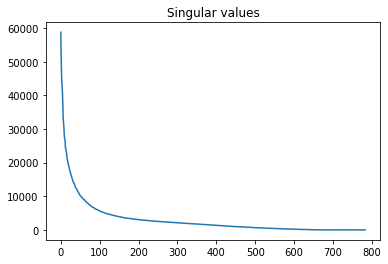

In [25]:
# Decomposition to get the eigenvectors of the covariance matrix:
y_test_mean = np.mean(y_test, axis=0)
y_test_centered = y_test - y_test_mean
U,S,V = np.linalg.svd(y_test_centered, full_matrices=False, compute_uv=True)
print(U.shape)
print(S.shape)
print(V.shape)

# The singular values:
plt.figure()
plt.plot(S)
plt.title('Singular values');

(10000, 64)
(64,)
(64, 784)


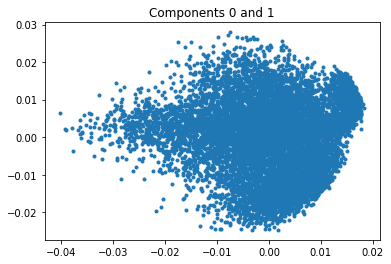

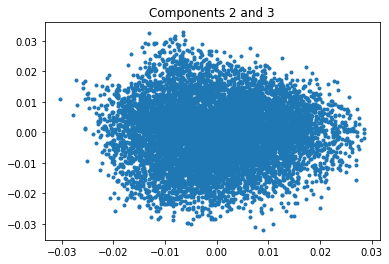

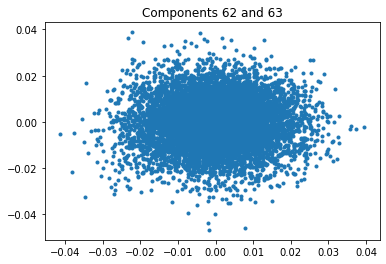

In [33]:
# Retaining only some components:
d = 64
Ud = U[:,0:d]
Sd = S[0:d]
Vd = V[0:d,:]
print(Ud.shape)
print(Sd.shape)
print(Vd.shape)

# Being A = U S V' => A V S^-1 = U ...
# ... then the coefficients in U are samples from as isotropic normal distribution:
def plot_components(i,j):
    plt.figure()
    plt.plot(Ud[:,i],Ud[:,j],'.')
    plt.title('Components %d and %d' % (i,j))

plot_components(0,1)
plot_components(2,3)
plot_components(d-2,d-1)

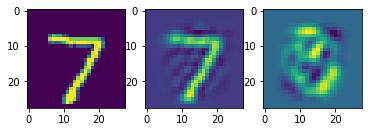

In [49]:
# The underlying distribution is not Gaussian...
# ...but let's try to sample it:

def reconstruct_image(coefs):
    if len(coefs) == d:
        Sm, Vm = Sd, Vd
    else:
        Sm, Vm = S, V
    return np.reshape((coefs*Sm).dot(Vm) + y_test_mean,(28,28))

plt.subplot(1,3,1)
plt.imshow(reconstruct_image(U[0,:]))
plt.subplot(1,3,2)
plt.imshow(reconstruct_image(Ud[0,:]))

coefs = np.random.normal(0,0.01,(d,))
plt.subplot(1,3,3)
plt.imshow(reconstruct_image(coefs));

The PCA seems to be a poor model for the MNIST dataset.

The data seem to be distributed more like a Mixture of Gaussians (MoG).

## MoG (GMM)

A GMM is a mixture of __k mutually exclusive gaussian distributions__.

A _discrate latent variable_ $\pi$ allow to choose a gaussian pdf $\mathcal{N}_k \equiv (\mu_k,\Lambda_k)$.

To sample from the GMM __first__ sample $k\sim\pi$, than sample $x\sim\mathcal{N}_k$.

Being the gaussian that generated the sample $x_n$ unknown, 
a latent variable $z_n$ represents the PDF over the gaussians.

The graphical model representing the GMM is the following one:

<img src="images/mog.png" width="500pt"/>

In [50]:
# Loading the tools:
%run GMM.py

# Applying the EM for gaussians to the data:
gmm = GMM(k=10)
gmm.fit(Ud[0:10000:10,:], max_iters=10)

Iteration 1: log-likelihood is 199283.272641
Iteration 2: log-likelihood is 207178.769124
Iteration 3: log-likelihood is 219902.615028
Iteration 4: log-likelihood is 236229.423902
Iteration 5: log-likelihood is 219705.064932
Terminate at 5-th iteration:log-likelihood is 219705.064932


In [51]:
# Preparing the distributions:
pi = lambda: stats.rv_discrete(
    values=(range(gmm.pi.shape[0]),gmm.pi)).rvs()
N = lambda k: stats.multivariate_normal.rvs(
    mean=np.squeeze(np.asarray(gmm.mean_arr[k])),
    cov=np.squeeze(np.asarray(gmm.sigma_arr[k])))

# Sampling from this distribution:
def gmm_sample():
    # Choosing the gaussian:
    k = pi()
    
    # Sampling from it:
    return N(k)

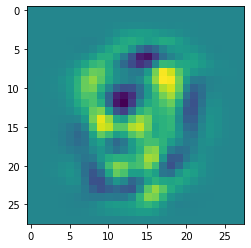

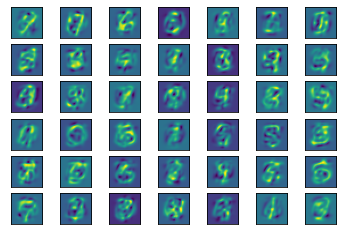

In [52]:
def imshowgrid(imgs):
    tot = len(imgs)
    m = int(np.ceil(np.sqrt(tot)))
    n = int(np.ceil(tot/m))
    plt.figure()
    for c in range(tot):
        ax = plt.subplot(n, m, c + 1)
        plt.imshow(imgs[c])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Showing samples:
plt.imshow(reconstruct_image(gmm_sample()))
imshowgrid([reconstruct_image(gmm_sample()) for _ in range(42)]);

Hard to capture the shape of the underlying distribution...

...can try with much more gaussians in the mixture...

...__must try with an ANN__!